In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
from scipy.optimize import root_scalar

aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
from aequilibrae.paths.path_based import TrafficAssignmentCy

import utils

In [4]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")

In [8]:
%%time
scenario = "Anaheim" #"Berlin-Center" #
num_iters = 10
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 6 #
cvxopt.solvers.options['abstol'] =1e-11
cvxopt.solvers.options['reltol'] =1e-11
cvxopt.solvers.options['feastol'] =1e-11

print(f"{datetime.now()} - Running scenario {scenario}")

folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")


### Build data structures
bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes, ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)
print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")
### end build ds

### initialise Ass, add ds
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

    
### Ini solution, iter 0
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()
costs = [t_assignment.get_objective_function()]
print(f"{datetime.now()} - done, cost = {costs[0]}")
gaps = [1]


### Iterations
solutions_per_origin = {}
od_path_times = {}

for i in range(num_iters):
    print(f"{datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        t_assignment.compute_shortest_paths(origin)
    #print(f"  {datetime.now()} - dijsktra done")
    
    for origin in origins:
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        solutions_per_origin[origin] = solution

# t_assignment.update_path_flows(origin, solutions_per_origin[origin])

    for origin in origins:
        t_assignment.update_current_iteration_flows_by_origin(origin, solutions_per_origin[origin])
    print(f"{datetime.now()} -   update done")

    # not parallel:
    try:
        min_res = root_scalar(lambda x: t_assignment.objective_derivative_stepsize(x), bracket=[0, 1])
        stepsize = min_res.root
    except ValueError:
        left_ = t_assignment.objective_derivative_stepsize(0)
        right_ = t_assignment.objective_derivative_stepsize(1)
        print(f"     error finding stepsize: {left_:.0f}, {right_:.0f}")
        # need to decide what to do here
        if left_ < right_:
            stepsize = 0.01
        else:
            stepsize = 0.99
    print(f"{datetime.now()} -   Stepsize finding done: {stepsize}")
    
    # update solution:
    t_assignment.update_link_flows_stepsize(stepsize)
    print(f"{datetime.now()} -   Blending link flows done")


    # now this can be parallel again
    for origin in origins:
        # update path flows: new_path_flows = (1-stepsize) * old_path_flow + stepsize * new_path_flow
        t_assignment.update_path_flows_stepsize(origin, stepsize)
        # 
    print(f"{datetime.now()} -   blended path flows")


    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times, p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)

    print(f"{datetime.now()} -   computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")

print(f"{datetime.now()} - Done")
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_ = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-06 23:44:58.852542 - Running scenario Berlin-Center
2020-12-06 23:44:59.576763 - num nodes = 12981, num links = 28370
2020-12-06 23:44:59.877889 - performing initial solution
2020-12-06 23:45:12.846123 - done, cost = 17175346.0
2020-12-06 23:45:12.847908 - starting iteration 0
2020-12-06 23:45:37.779604 -   update done
2020-12-06 23:45:39.688805 -   Stepsize finding done: 0.6544771539179624
2020-12-06 23:45:39.760167 -   Blending link flows done
2020-12-06 23:45:39.760707 -   blended path flows
2020-12-06 23:45:39.922636 -   computed path times and flows, computed gap: 0.09925154779864509, computed objective: 13913536.0
2020-12-06 23:45:39.922762 - starting iteration 1
2020-12-06 23:46:09.833367 -   update done
2020-12-06 23:46:11.780895 -   Stepsize finding done: 0.32542265729978825
2020-12-06 23:46:11.856456 -   Blending link flows done
2020-12-06 23:46:11.857013 -   blended path flows
2020-12-06 23:46:12.039295 -   computed path times and flows, computed gap: 0.0561781049867

In [9]:
%%time
compare_flows = True
if compare_flows:
    bfw_res_ = utils.get_gradient_descent_solution(tntp_dir, scenario, link_file, block_centroids=False, rgap=5*1e-5)

CPU times: user 8min 50s, sys: 6.91 s, total: 8min 57s
Wall time: 1min 18s


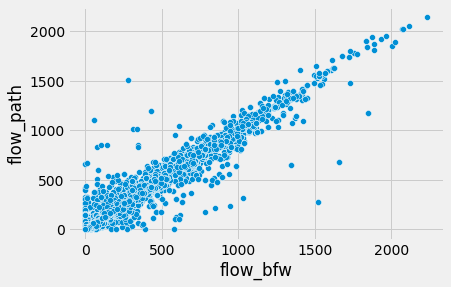

max diff in flow = 1241.328
max rel diff in flow = inf%


,link_id,a_node,b_node,ff_time,capacity,alpha,beta,direction,flow_bfw,flow_path,abs_change,rel_change
18848,18848,8426,413,0.0,999999.0,0.0,4.0,1,1520.377608,279.049561,1241.328047,0.816460
2090,2090,419,8426,0.0,999999.0,0.0,4.0,1,1520.377608,279.049561,1241.328047,0.816460
19490,19490,8720,413,0.0,999999.0,0.0,4.0,1,279.816726,1507.517944,1227.701218,4.387519
2092,2092,419,8720,0.0,999999.0,0.0,4.0,1,279.816726,1507.517944,1227.701218,4.387519
2061,2061,413,8720,0.0,999999.0,0.0,4.0,1,53.758538,1107.706543,1053.948005,19.605221
19491,19491,8720,419,0.0,999999.0,0.0,4.0,1,53.758538,1107.706543,1053.948005,19.605221
18849,18849,8426,419,0.0,999999.0,0.0,4.0,1,1661.021767,678.683960,982.337807,0.591406
2060,2060,413,8426,0.0,999999.0,0.0,4.0,1,1661.021767,678.683960,982.337807,0.591406
18725,18725,8370,413,0.0,999999.0,0.0,4.0,1,430.707761,1190.751709,760.043948,1.764640
2087,2087,418,8370,0.0,999999.0,0.0,4.0,1,430.707761,1190.751709,760.043948,1.764640


CPU times: user 188 ms, sys: 62.5 ms, total: 250 ms
Wall time: 230 ms


In [10]:
%%time
compare_flows = True
if compare_flows:
    full_result = bfw_res_.rename(columns={'time': 'ff_time'}).merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
    sns.scatterplot(data=full_result, x='flow_bfw', y='flow_path');
    plt.show();
    full_result['abs_change'] = np.abs(full_result.flow_bfw - full_result.flow_path)
    full_result['rel_change'] = full_result['abs_change'] / full_result['flow_bfw']
    print(f"max diff in flow = {full_result['abs_change'].max():.3f}")
    print(f"max rel diff in flow = {full_result['rel_change'].abs().max():.3f}%")
    display(full_result.sort_values(by=['abs_change'], ascending=False).head(10))

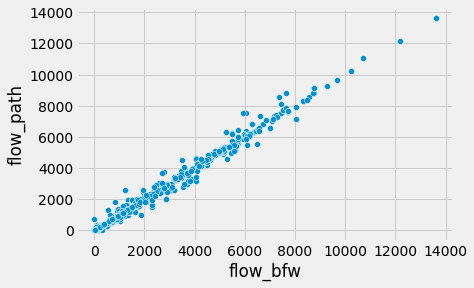

max diff in flow = 1581.170
max rel diff in flow = 281717351.000%


,link_id,a_node,b_node,ff_time,capacity,direction,flow_bfw,flow_path,abs_change,rel_change
423,423,269,25,0.149068,12600,1,5949.637996,7530.808105,1581.170109,0.265759
31,31,25,268,0.149068,12600,1,6041.763444,7517.914551,1476.151107,0.244325
131,131,83,261,0.500000,1800,1,1213.546166,2613.723633,1400.177466,1.153790
398,398,261,269,1.859848,5400,1,1213.546166,2613.723633,1400.177466,1.153790
645,645,337,29,0.149068,12600,1,7646.594981,8823.935547,1177.340566,0.153969
39,39,29,308,0.149068,12600,1,7376.994952,8541.153320,1164.158369,0.157809
179,179,115,114,0.229038,7200,1,5240.774880,6300.018555,1059.243675,0.202116
178,178,114,113,0.316192,7200,1,5240.774880,6300.018555,1059.243675,0.202116
492,492,294,115,0.500000,1800,1,832.368936,1834.194702,1001.825766,1.203584
177,177,113,195,0.333333,7200,1,3490.868891,4492.694336,1001.825445,0.286985


CPU times: user 188 ms, sys: 78.1 ms, total: 266 ms
Wall time: 252 ms


In [ ]:
# Cannot compare, best solution blocks flows through centroids. Agrees with BFW, so let's go with comparison to that
# #if scenario == "Anaheim":
# best_ = pd.read_csv(os.path.join(tntp_dir, scenario, "Anaheim_flow.tntp"), skiprows=5, sep="\t")
# best_ = best_.drop(columns=['~ ', ": ", "; "])
# best_ = best_.rename(columns={"Tail ": "a_node", "Head ": "b_node", "Volume ": "flow_best"})
# full_result = best_.merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer')
# sns.scatterplot(data=full_result, x='flow_best', y='flow');